### 解析法求解
稳态的单群扩散方程：
$$
D_i \frac{\partial^2\phi}{\partial x^2} - \Sigma_{ai} \phi + \nu\Sigma_{fi} \phi = -\frac{1}{v}\frac{\partial\phi}{\partial t}=0
$$
分离变量法：$$\phi(x,t)=\varphi(x)T(t)$$
代入原方程
$$\frac{d^2\varphi}{dx^2} + B_i^2 \varphi = 0,\quad
B_i^2 = \frac{\nu\Sigma_{fi} - \Sigma_{ai}}{D_i}$$
解得
$$\varphi_i (x)=A_i\cos (B_i x)+C_i\sin (B_i x)$$



区域 1（左反射层r）：$0 \le x_1 \le \delta$

区域 2（堆芯1 ）：$\delta \le x_2 \le \delta +R$

区域 3（堆芯 2）：$\delta +R \le x_3 \le \delta +2R$

区域 4（右反射层r）：$\delta +2R \le x_4 \le 2\delta +2R$



边界条件：
$$\varphi_1(0)=0$$
$$\varphi_1(\delta)=\varphi_2(delta)$$
$$\varphi_2(\delta+R)=\varphi_3(delta+R)$$
$$\varphi_3(\delta+2R)=\varphi_4(delta+R)$$
$$\varphi_4(2\delta+2R)=0$$

<>:128: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:128: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
C:\Users\54645\AppData\Local\Temp\ipykernel_296\4218419020.py:128: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x, phi_result, label=' $\phi(x)$')
C:\Users\54645\AppData\Local\Temp\ipykernel_296\4218419020.py:131: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Normalized Neutron Flux $\phi(x)$')


计算收敛，迭代次数: 356
最终有效增殖因数 k_eff: 1.525545

--- 结果 ---
最终有效增殖因数 (k_eff): 1.52555


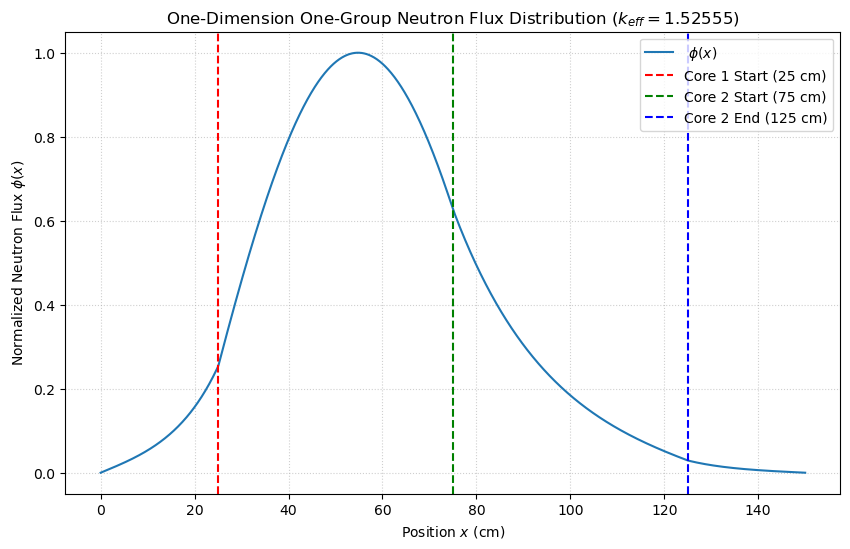

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def solve_one_dimension_one_group_reactor():
    # 初始参数设置
    D_1=0.65
    D_2=0.75
    D_r=1.15
    Sigma_a_1=0.12
    Sigma_a_2=0.10
    Sigma_a_r=0.01
    nu_Sigma_f_1=0.185
    nu_Sigma_f_2=0.15
    nu_Sigma_f_r=0.0
    L_1=np.sqrt(D_1/Sigma_a_1)
    L_2=np.sqrt(D_2/Sigma_a_2)
    L_r=np.sqrt(D_r/Sigma_a_r)
    delta=25
    R=50
    H=2*delta+2*R # 总宽度
    h=0.1 # 网格宽度
    N= int(H/h)+1  # 网格数
    boundary_1=delta
    boundary_2=delta+R
    boundary_3=delta+2*R
    x = np.linspace(0, H, N)

    # 更新的参数初始化
    phi = np.ones(N) # 初始通量
    phi[0] = 0.0 # 外推边界条件
    phi[-1] = 0.0 # 外推边界条件
    k_eff_old = 1.0
    max_iteration = 1000
    epsilon = 1e-6
    k_eff_history = []
    phi_history = []

    # 计算涉及的参数赋值
    D = np.zeros(N)
    Sigma_a = np.zeros(N)
    Nu_Sigma_f = np.zeros(N)
    
    idx_1 = x <= boundary_1
    D[idx_1] = D_r
    Sigma_a[idx_1] = Sigma_a_r
    Nu_Sigma_f[idx_1] = nu_Sigma_f_r

    idx_II = (x > boundary_1) & (x <= boundary_2)
    D[idx_II] = D_1
    Sigma_a[idx_II] = Sigma_a_1
    Nu_Sigma_f[idx_II] = nu_Sigma_f_1

    idx_III = (x > boundary_2) & (x <= boundary_3)
    D[idx_III] = D_2
    Sigma_a[idx_III] = Sigma_a_2
    Nu_Sigma_f[idx_III] = nu_Sigma_f_2

    idx_IV = x > boundary_3
    D[idx_IV] = D_r
    Sigma_a[idx_IV] = Sigma_a_r
    Nu_Sigma_f[idx_IV] = nu_Sigma_f_r

    # 计算
    D_inner = np.zeros(N-1) # 内部节点间计算用的扩散系数
    for i in range(N-1):
        D_inner[i] = 0.5 * (D[i] + D[i+1])

    A = np.zeros((N, N)) # 系数矩阵
    A[0, 0] = 1.0      # φ_0 = 0
    A[N-1, N-1] = 1.0  # φ_{N-1} = 0
    for i in range(1, N-1):
        A[i, i-1] = -D_inner[i-1] / (h**2)
        A[i, i] = (D_inner[i-1] + D_inner[i]) / (h**2) + Sigma_a[i]
        A[i, i+1] = -D_inner[i] / (h**2)
    
    
    B = np.zeros((N, N)) # 系数矩阵
    for i in range(N):
        B[i, i] = Nu_Sigma_f[i]
    
    
    for i in range(max_iteration):
        # 第i-1代裂变源项
        S_old = B @ phi
        # 第i代有效裂变源项
        F_new = S_old / k_eff_old
        F_new[0] = 0.0 # 外推边界条件
        F_new[-1] = 0.0 # 外推边界条件
        
        # 第i代中子通量
        phi_new = np.linalg.solve(A, F_new)
        
        # 第i代裂变源项
        S_new = B @ phi_new
        
        # 第i代有效增殖系数
        k_eff_new = k_eff_old * np.sum(S_new) / np.sum(S_old)
        
        # 中子通量归一化
        phi_new_norm = phi_new / np.max(np.abs(phi_new))
        phi_new_norm[0] = 0.0 # 外推边界条件
        phi_new_norm[-1] = 0.0 # 外推边界条件
        
        # 检查收敛性
        phi_diff = np.max(np.abs(phi_new_norm - phi))
        k_eff_diff = np.abs(k_eff_new - k_eff_old)
        
        k_eff_history.append(k_eff_new)
        phi_history.append(phi_new_norm.copy())
        
        if (k_eff_diff < epsilon) and (phi_diff < epsilon):
            print(f"计算收敛，迭代次数: {i+1}")
            print(f"最终有效增殖因数 k_eff: {k_eff_new:.6f}")
            break
        
        # 更新
        phi = phi_new_norm
        k_eff_old = k_eff_new
        
        if i == max_iteration - 1:
            print("未在最大迭代次数内收敛。")
    
    # 画图
    k_eff_result = k_eff_history[-1]
    phi_result = phi
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, phi_result, label=' $\phi(x)$')
    plt.title(f'One-Dimension One-Group Neutron Flux Distribution ($k_{{eff}} = {k_eff_result:.5f}$)')
    plt.xlabel('Position $x$ (cm)')
    plt.ylabel('Normalized Neutron Flux $\phi(x)$')
    
    # 标出区域边界
    plt.axvline(boundary_1, color='r', linestyle='--', label=f'Core 1 Start ({boundary_1} cm)')
    plt.axvline(boundary_2, color='g', linestyle='--', label=f'Core 2 Start ({boundary_2} cm)')
    plt.axvline(boundary_3, color='b', linestyle='--', label=f'Core 2 End ({boundary_3} cm)')
    
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    
    # 保存绘图和数据
    plt.savefig('neutron_flux_distribution.png')
    np.savetxt('neutron_flux_distribution_1d.csv', np.vstack([x, phi_result]).T, header='Position_x_cm,Flux_phi', delimiter=',')

    print("\n--- 结果 ---")
    print(f"最终有效增殖因数 (k_eff): {k_eff_result:.5f}")

if __name__ == '__main__':
    solve_one_dimension_one_group_reactor()